(uncertainty_traps)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Uncertainty Traps

```{contents} Contents
:depth: 2
```

## Overview

In this lecture, we study a simplified version of an uncertainty traps model of Fajgelbaum, Schaal and Taschereau-Dumouchel {cite}`fun`.

The model features self-reinforcing uncertainty that has big impacts on economic activity.

In the model,

* Fundamentals  vary stochastically and are not fully observable.
* At any moment there are both active and inactive entrepreneurs; only active entrepreneurs produce.
* Agents -- active and inactive entrepreneurs --  have beliefs about the fundamentals expressed as probability distributions.
* Greater uncertainty means greater dispersions of these distributions.
* Entrepreneurs are risk-averse and hence less inclined to be active  when uncertainty is high.
* The output of active entrepreneurs is observable, supplying a noisy signal that helps everyone inside the model infer fundamentals.
* Entrepreneurs update their beliefs about fundamentals using Bayes' Law, implemented via {doc}`Kalman filtering <kalman>`.

Uncertainty traps emerge because:

* High uncertainty discourages entrepreneurs from becoming active.
* A low level of participation -- i.e., a smaller number of active entrepreneurs -- diminishes the flow of information about fundamentals.
* Less information translates to higher uncertainty, further discouraging entrepreneurs from choosing to be active, and so on.

Uncertainty traps stem from a positive externality: high aggregate economic activity levels generates valuable information.

Let's start with some standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import itertools

## The Model

The original model described in {cite}`fun` has many interesting moving parts.

Here we examine a simplified version that nonetheless captures many of the key ideas.

### Fundamentals

The evolution of the fundamental process $\{\theta_t\}$ is given by

$$
\theta_{t+1} = \rho \theta_t + \sigma_{\theta} w_{t+1}
$$

where

* $\sigma_\theta > 0$ and $0 < \rho < 1$
* $\{w_t\}$ is IID and standard normal

The random variable $\theta_t$ is not observable at any time.

### Output

There is a total $\bar M$ of risk-averse entrepreneurs.

Output of the $m$-th entrepreneur, conditional on being active in the market at
time $t$, is equal to

```{math}
:label: xgt

x_m = \theta + \epsilon_m
\quad \text{where} \quad
\epsilon_m \sim N \left(0, \gamma_x^{-1} \right)
```

Here the time subscript has been dropped to simplify notation.

The inverse of the shock variance, $\gamma_x$, is called the shock's **precision**.

The higher is the precision, the more informative $x_m$ is about the fundamental.

Output shocks are independent across time and firms.

### Information and Beliefs

All entrepreneurs start with identical beliefs about $\theta_0$.

Signals are publicly observable and hence all agents have identical beliefs always.

Dropping time subscripts, beliefs for current $\theta$ are represented by the normal
distribution $N(\mu, \gamma^{-1})$.

Here $\gamma$ is the precision of beliefs; its inverse is the degree of uncertainty.

These parameters are updated by Kalman filtering.

Let

* $\mathbb M \subset \{1, \ldots, \bar M\}$ denote the set of currently active firms.
* $M := |\mathbb M|$ denote the number of currently active firms.
* $X$ be the average output $\frac{1}{M} \sum_{m \in \mathbb M} x_m$ of the active firms.

With this notation and primes for next period values, we can write the updating of the mean and precision via

```{math}
:label: update_mean

\mu' = \rho \frac{\gamma \mu + M \gamma_x X}{\gamma + M \gamma_x}
```

```{math}
:label: update_prec

\gamma' =
    \left(
    \frac{\rho^2}{\gamma + M \gamma_x} + \sigma_\theta^2
    \right)^{-1}
```

These are standard Kalman filtering results applied to the current setting.

Exercise 1 provides more details on how {eq}`update_mean` and {eq}`update_prec` are derived and then asks you to fill in remaining steps.

The next figure plots the law of motion for the precision in {eq}`update_prec`
as a 45 degree diagram, with one curve for each $M \in \{0, \ldots, 6\}$.

The other parameter values are $\rho = 0.99, \gamma_x = 0.5, \sigma_\theta =0.5$

```{figure} /_static/lecture_specific/uncertainty_traps/uncertainty_traps_45.png

```

Points where the curves hit the 45 degree lines are  long-run steady
states for precision for different values of $M$.

Thus, if one of these values for $M$ remains fixed, a corresponding steady state is the equilibrium level of precision

* high values of $M$ correspond to greater information about the
  fundamental, and hence more precision in steady state
* low values of $M$ correspond to less information and more uncertainty in steady state

In practice, as we'll see, the number of active firms fluctuates stochastically.

### Participation

Omitting time subscripts once more, entrepreneurs enter the market in the current period if

```{math}
:label: pref1

\mathbb E [ u(x_m - F_m) ] > c
```

Here

* the mathematical expectation of $x_m$ is based on {eq}`xgt` and beliefs $N(\mu, \gamma^{-1})$ for $\theta$
* $F_m$ is a stochastic but pre-visible fixed cost, independent across time and firms
* $c$ is a constant reflecting opportunity costs

The statement that $F_m$ is pre-visible means that it is realized at the start of the period and treated as a constant in {eq}`pref1`.

The utility function has the constant absolute risk aversion form

```{math}
:label: pref2

u(x) = \frac{1}{a} \left(1 - \exp(-a x) \right)
```

where $a$ is a positive parameter.

Combining {eq}`pref1` and {eq}`pref2`, entrepreneur $m$ participates in the market (or is said to be active) when

$$
\frac{1}{a}
    \left\{
        1 - \mathbb E [ \exp \left(
            -a (\theta + \epsilon_m -  F_m)
                \right) ]
    \right\}
        > c
$$

Using standard formulas for expectations of [lognormal](https://en.wikipedia.org/wiki/Log-normal_distribution) random variables, this is equivalent to the condition

```{math}
:label: firm_test

\psi(\mu, \gamma, F_m) :=
\frac{1}{a}
    \left(
        1 - \exp \left(
            -a \mu + a F_m +
            \frac{a^2 \left( \frac{1}{\gamma} + \frac{1}{\gamma_x} \right)}{2}
                \right)
    \right) - c  > 0
```

## Implementation

We want to simulate this economy.

As a first step, let's put together a class that bundles

* the parameters, the current value of $\theta$ and the current values of the
  two belief parameters $\mu$ and $\gamma$
* methods to update $\theta$, $\mu$ and $\gamma$, as well as to determine the number of active firms and their outputs

The updating methods follow the laws of motion for $\theta$, $\mu$ and $\gamma$ given above.

The method to evaluate the number of active firms generates $F_1,
\ldots, F_{\bar M}$ and tests condition {eq}`firm_test` for each firm.

The __init__ method encodes as default values the parameters we'll use in the simulations below

In [2]:
class UncertaintyTrapEcon:

    def __init__(self,
                a=1.5,          # Risk aversion
                γ_x=0.5,        # Production shock precision
                ρ=0.99,         # Correlation coefficient for θ
                σ_θ=0.5,        # Standard dev of θ shock
                num_firms=100,  # Number of firms
                σ_F=1.5,        # Standard dev of fixed costs
                c=-420,         # External opportunity cost
                μ_init=0,       # Initial value for μ
                γ_init=4,       # Initial value for γ
                θ_init=0):      # Initial value for θ

        # == Record values == #
        self.a, self.γ_x, self.ρ, self.σ_θ = a, γ_x, ρ, σ_θ
        self.num_firms, self.σ_F, self.c, = num_firms, σ_F, c
        self.σ_x = np.sqrt(1/γ_x)

        # == Initialize states == #
        self.γ, self.μ, self.θ = γ_init, μ_init, θ_init

    def ψ(self, F):
        temp1 = -self.a * (self.μ - F)
        temp2 = self.a**2 * (1/self.γ + 1/self.γ_x) / 2
        return (1 / self.a) * (1 - np.exp(temp1 + temp2)) - self.c

    def update_beliefs(self, X, M):
        """
        Update beliefs (μ, γ) based on aggregates X and M.
        """
        # Simplify names
        γ_x, ρ, σ_θ = self.γ_x, self.ρ, self.σ_θ
        # Update μ
        temp1 = ρ * (self.γ * self.μ + M * γ_x * X)
        temp2 = self.γ + M * γ_x
        self.μ = temp1 / temp2
        # Update γ
        self.γ = 1 / (ρ**2 / (self.γ + M * γ_x) + σ_θ**2)

    def update_θ(self, w):
        """
        Update the fundamental state θ given shock w.
        """
        self.θ = self.ρ * self.θ + self.σ_θ * w

    def gen_aggregates(self):
        """
        Generate aggregates based on current beliefs (μ, γ). This
        is a simulation step that depends on the draws for F.
        """
        F_vals = self.σ_F * np.random.randn(self.num_firms)
        M = np.sum(self.ψ(F_vals) > 0)  # Counts number of active firms
        if M > 0:
            x_vals = self.θ + self.σ_x * np.random.randn(M)
            X = x_vals.mean()
        else:
            X = 0
        return X, M

In the results below we use this code to simulate time series for the major variables.

## Results

Let's look first at the dynamics of $\mu$, which the agents use to track $\theta$

```{figure} /_static/lecture_specific/uncertainty_traps/uncertainty_traps_mu.png

```

We see that $\mu$ tracks $\theta$ well when there are sufficient firms in the market.

However, there are times when $\mu$ tracks $\theta$ poorly due to
insufficient information.

These are episodes where the uncertainty traps take hold.

During these episodes

* precision is low and uncertainty is high
* few firms are in the market

To get a clearer idea of the dynamics, let's look at all the main time series
at once, for a given set of shocks

```{figure} /_static/lecture_specific/uncertainty_traps/uncertainty_traps_sim.png
```

Notice how the traps only take hold after a sequence of bad draws for the fundamental.

Thus, the model gives us a *propagation mechanism* that maps bad random draws into long downturns in economic activity.

## Exercises

```{exercise}
:label: uncertainty_traps_ex1

Fill in the details behind {eq}`update_mean` and {eq}`update_prec` based on
the following standard result (see, e.g., p. 24 of {cite}`young2005`).

**Fact** Let $\mathbf x = (x_1, \ldots, x_M)$ be a vector of IID draws
from common distribution $N(\theta, 1/\gamma_x)$
and let $\bar x$ be the sample mean.  If $\gamma_x$
is known and the prior for $\theta$ is $N(\mu, 1/\gamma)$, then the posterior
distribution of $\theta$ given $\mathbf x$ is

$$
\pi(\theta \,|\, \mathbf x) = N(\mu_0, 1/\gamma_0)
$$

where

$$
\mu_0 = \frac{\mu \gamma + M \bar x \gamma_x}{\gamma + M \gamma_x}
\quad \text{and} \quad
\gamma_0 = \gamma + M \gamma_x
$$
```

```{solution} uncertainty_traps_ex1
:class: dropdown

This exercise asked you to validate the laws of motion for
$\gamma$ and $\mu$ given in the lecture, based on the stated
result about Bayesian updating in a scalar Gaussian setting. The stated
result tells us that after observing average output $X$ of the
$M$ firms, our posterior beliefs will be

$$
N(\mu_0, 1/\gamma_0)
$$

where

$$
\mu_0 = \frac{\mu \gamma + M X \gamma_x}{\gamma + M \gamma_x}
\quad \text{and} \quad
\gamma_0 = \gamma + M \gamma_x
$$

If we take a random variable $\theta$ with this distribution and
then evaluate the distribution of $\rho \theta + \sigma_\theta w$
where $w$ is independent and standard normal, we get the
expressions for $\mu'$ and $\gamma'$ given in the lecture.
```

```{exercise}
:label: uncertainty_traps_ex2

Modulo randomness, replicate the simulation figures shown above.

* Use the parameter values listed as defaults in the __init__ method of the UncertaintyTrapEcon class.
```

```{solution-start} uncertainty_traps_ex2
:class: dropdown
```

First, let's replicate the plot that illustrates the law of motion for
precision, which is

$$
\gamma_{t+1} =
    \left(
    \frac{\rho^2}{\gamma_t + M \gamma_x} + \sigma_\theta^2
    \right)^{-1}
$$

Here $M$ is the number of active firms. The next figure plots
$\gamma_{t+1}$ against $\gamma_t$ on a 45 degree diagram for
different values of $M$

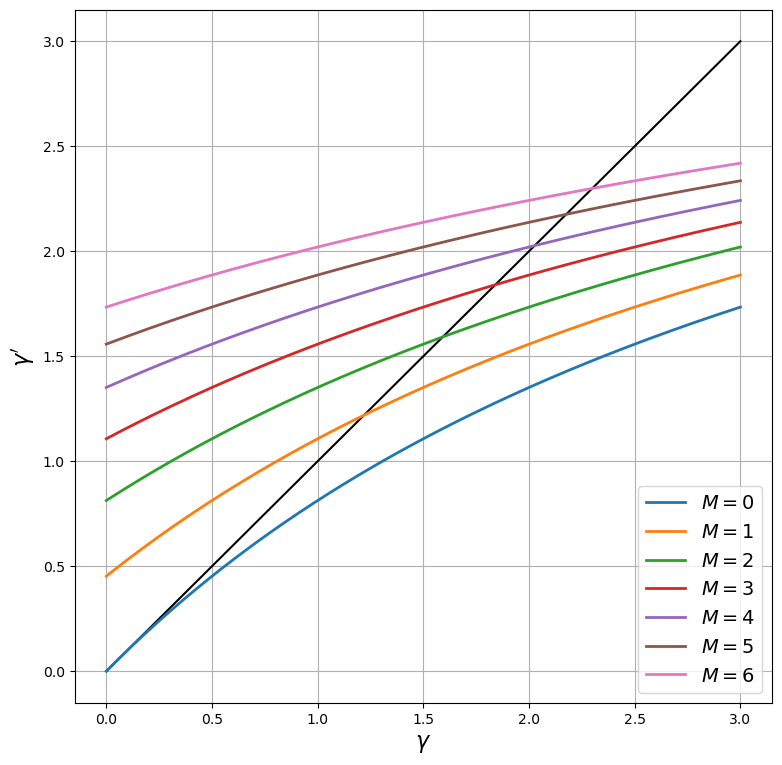

In [3]:
econ = UncertaintyTrapEcon()
ρ, σ_θ, γ_x = econ.ρ, econ.σ_θ, econ.γ_x    # Simplify names
γ = np.linspace(1e-10, 3, 200)              # γ grid
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(γ, γ, 'k-')                         # 45 degree line

for M in range(7):
    γ_next = 1 / (ρ**2 / (γ + M * γ_x) + σ_θ**2)
    label_string = f"$M = {M}$"
    ax.plot(γ, γ_next, lw=2, label=label_string)
ax.legend(loc='lower right', fontsize=14)
ax.set_xlabel(r'$\gamma$', fontsize=16)
ax.set_ylabel(r"$\gamma'$", fontsize=16)
ax.grid()
plt.show()

The points where the curves hit the 45 degree lines are the long-run
steady states corresponding to each $M$, if that value of
$M$ was to remain fixed. As the number of firms falls, so does the
long-run steady state of precision.

Next let's generate time series for beliefs and the aggregates -- that
is, the number of active firms and average output

In [4]:
sim_length=2000

μ_vec = np.empty(sim_length)
θ_vec = np.empty(sim_length)
γ_vec = np.empty(sim_length)
X_vec = np.empty(sim_length)
M_vec = np.empty(sim_length)

μ_vec[0] = econ.μ
γ_vec[0] = econ.γ
θ_vec[0] = 0

w_shocks = np.random.randn(sim_length)

for t in range(sim_length-1):
    X, M = econ.gen_aggregates()
    X_vec[t] = X
    M_vec[t] = M

    econ.update_beliefs(X, M)
    econ.update_θ(w_shocks[t])

    μ_vec[t+1] = econ.μ
    γ_vec[t+1] = econ.γ
    θ_vec[t+1] = econ.θ

# Record final values of aggregates
X, M = econ.gen_aggregates()
X_vec[-1] = X
M_vec[-1] = M

First, let's see how well $\mu$ tracks $\theta$ in these
simulations

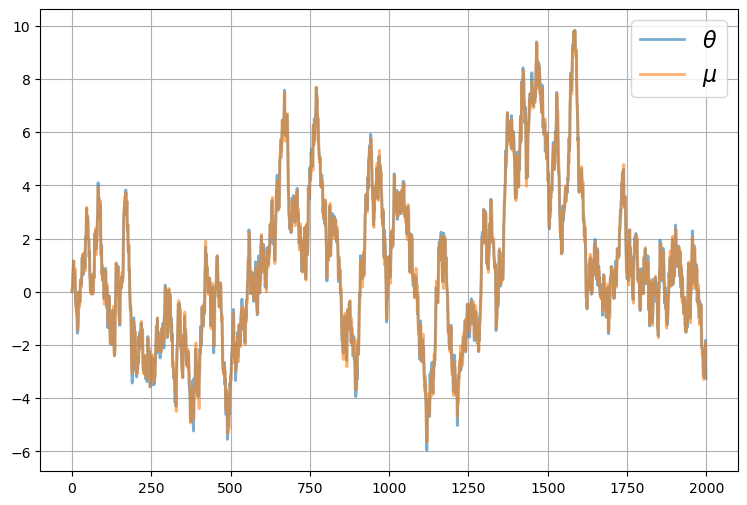

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(sim_length), θ_vec, alpha=0.6, lw=2, label=r"$\theta$")
ax.plot(range(sim_length), μ_vec, alpha=0.6, lw=2, label=r"$\mu$")
ax.legend(fontsize=16)
ax.grid()
plt.show()

Now let's plot the whole thing together

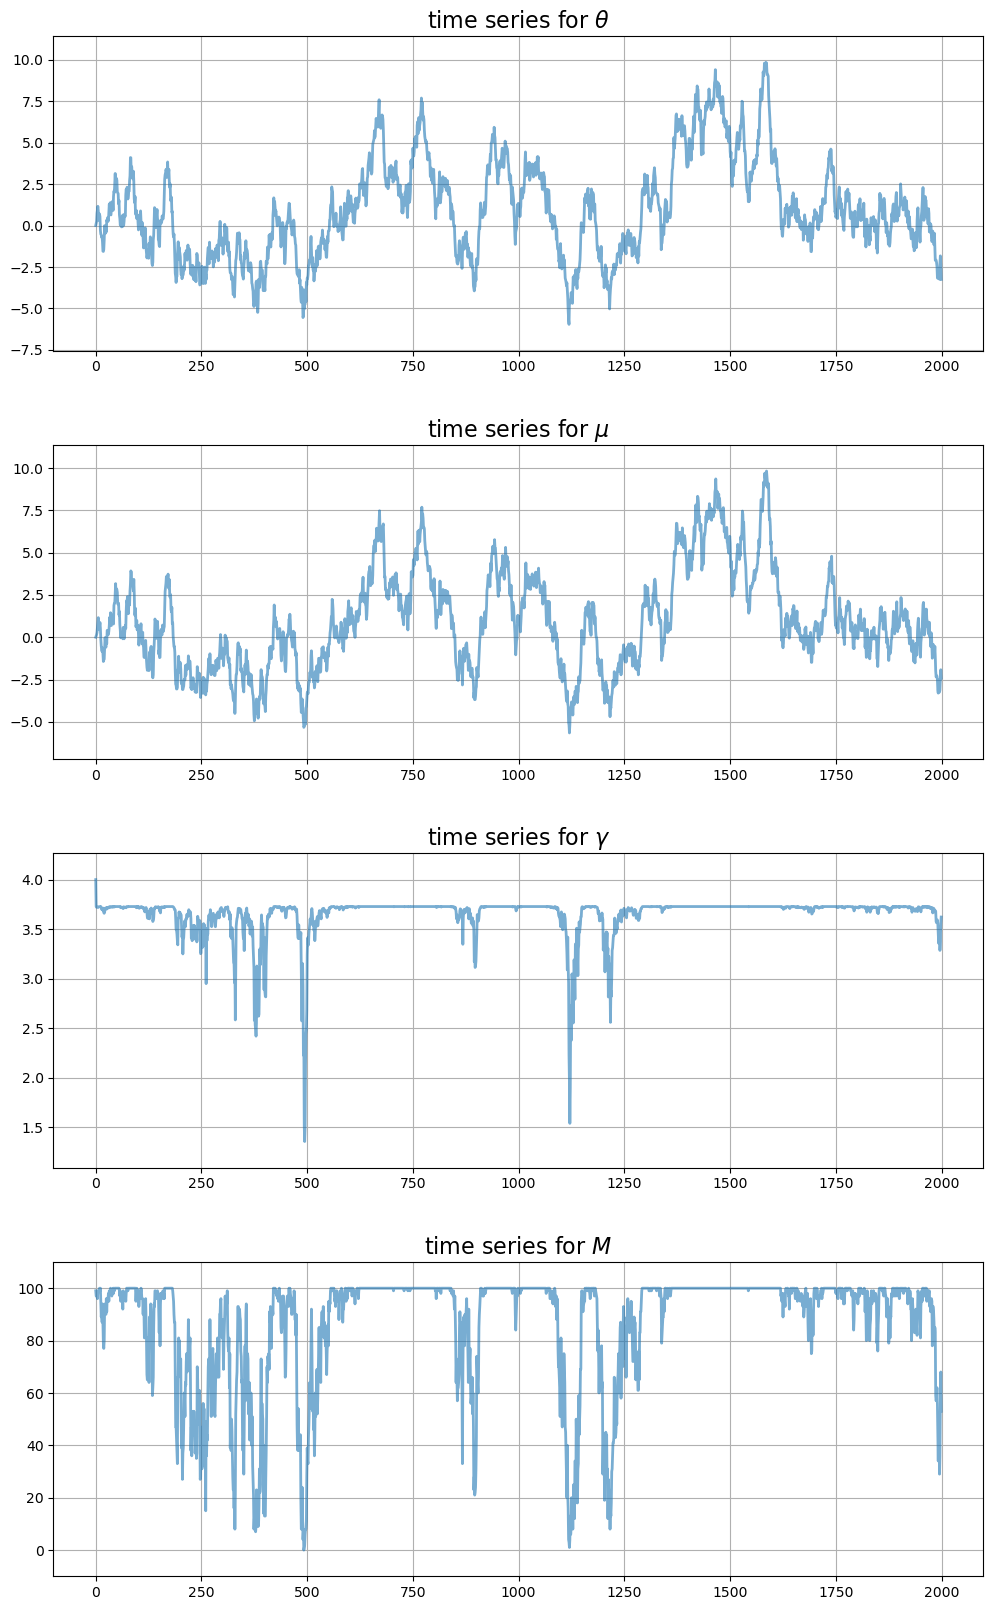

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
# Add some spacing
fig.subplots_adjust(hspace=0.3)

series = (θ_vec, μ_vec, γ_vec, M_vec)
names = r'$\theta$', r'$\mu$', r'$\gamma$', r'$M$'

for ax, vals, name in zip(axes, series, names):
    # Determine suitable y limits
    s_max, s_min = max(vals), min(vals)
    s_range = s_max - s_min
    y_max = s_max + s_range * 0.1
    y_min = s_min - s_range * 0.1
    ax.set_ylim(y_min, y_max)
    # Plot series
    ax.plot(range(sim_length), vals, alpha=0.6, lw=2)
    ax.set_title(f"time series for {name}", fontsize=16)
    ax.grid()

plt.show()

If you run the code above you'll get different plots, of course.

Try experimenting with different parameters to see the effects on the time
series.

(It would also be interesting to experiment with non-Gaussian
distributions for the shocks, but this is a big exercise since it takes
us outside the world of the standard Kalman filter)

```{solution-end}
```